# AutoEncoder
 



## 0.환경준비

### 0.1 라이브러리 로딩

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.backend import clear_session
from tensorflow.keras.utils import plot_model

### 0.2 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [2]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)
    
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [3]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, 0), label = 'precision')
    plt.plot(thresholds, np.delete(recall, 0), label = 'recall')
    plt.plot(thresholds, np.delete(f1, 0), label = 'f1')
    plt.xlabel('Threshold')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    cm = confusion_matrix(y, pred_temp)
    print('< confusion matrix >\n')
    print(cm)
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return cm

## 1.AE 연습 : 직원 이직 예측

* 일부 데이터를 뽑아서 AutoEncoder를 만들어 봅시다.

### 1.1 데이터 준비

#### 1) 데이터 로딩

In [5]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path, usecols = ['Attrition', 'Age', 'DistanceFromHome', 'MaritalStatus', 'MonthlyIncome'])
data['Single'] = np.where(data['MaritalStatus'] == 'Single', 1, 0)
data.drop('MaritalStatus', axis = 1, inplace = True)

data.rename(columns={"DistanceFromHome": "Distance", "MonthlyIncome": "Income"}, inplace = True)
data.head(10)

,Attrition,Age,Distance,Income,Single
0,0,28,1,3591,0
1,1,37,2,2090,1
2,0,27,8,4621,0
3,0,18,1,1611,1
4,0,29,9,2451,0
5,0,44,2,10209,1
6,0,41,10,6230,1
7,0,25,18,6232,0
8,0,50,2,17639,0
9,0,47,4,4163,1


#### 2) x, y 나누기 

In [6]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [7]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

#### 3) 데이터 분할

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state = 2022)

In [10]:
print(x_train.shape, x_val.shape)

(805, 4) (345, 4)


#### 4) 스케일링

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

#### 5) 학습용 데이터 준비
* 학습에는 x_train만 사용됩니다.(비지도)
* 또한, x_train 중에서도 Normal 데이터만 이용합니다.

In [12]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train_s[y_train == 0]

In [13]:
x_train0.shape

(727, 4)

### 1.2 모델링 : AE

#### 1) hyper parameter 설정

In [14]:
epochs = 50
input_dim = x_train0.shape[1] #num of columns
input_dim

tf.random.set_seed(10)

#### 2) 모델 설계

![](https://github.com/DA4BAM/dataset/blob/master/ae_1.png?raw=true)

In [15]:
clear_session()

input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(4, activation="relu")(input_layer)
encoder = Dense(2, activation="relu")(encoder)

# Decoder
decoder = Dense(4, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


#### 3) compile + 학습
* 학습시 x=x_train0, y=x_train0를 입력합니다. (비지도)

In [16]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=epochs,
                          validation_data=(x_val_s, x_val_s)).history

Epoch 1/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1847 - accuracy: 0.1774 - val_loss: 0.1853 - val_accuracy: 0.1391
Epoch 2/50
23/23 [==============================] - 0s 1ms/step - loss: 0.1598 - accuracy: 0.3040 - val_loss: 0.1604 - val_accuracy: 0.3971
Epoch 3/50
23/23 [==============================] - 0s 1ms/step - loss: 0.1383 - accuracy: 0.4044 - val_loss: 0.1398 - val_accuracy: 0.3971
Epoch 4/50
23/23 [==============================] - 0s 1ms/step - loss: 0.1210 - accuracy: 0.4058 - val_loss: 0.1244 - val_accuracy: 0.3971
Epoch 5/50
23/23 [==============================] - 0s 1ms/step - loss: 0.1086 - accuracy: 0.4058 - val_loss: 0.1139 - val_accuracy: 0.3971
Epoch 6/50
23/23 [==============================] - 0s 1ms/step - loss: 0.1006 - accuracy: 0.4058 - val_loss: 0.1075 - val_accuracy: 0.3971
Epoch 7/50
23/23 [==============================] - 0s 1ms/step - loss: 0.0957 - accuracy: 0.4058 - val_loss: 0.1036 - val_accuracy: 0.3971
Epoch 8/50
23/23 [==

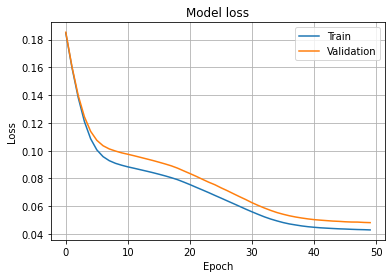

In [17]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

### 1.3 예측 및 Reconstruction Error 계산

* 예측

In [18]:
pred = autoencoder.predict(x_val_s)

* 재구성 에러 계산

    * recon_err_plot(y, y_pred, threshold)
        * threshlod는 임의로 지정하는 값입니다.
    * 그래프에서
        * x 축 : 각 데이터(instance, 행) 인덱스
        * y 축 : 각 데이터(instance, 행) - 예측값과의 재구성 에러
        * 파란색점과 주황색점은 실제값을 나타냅니다.
        * 빨간선 : 임의로 지정한 threshold(cutoff)

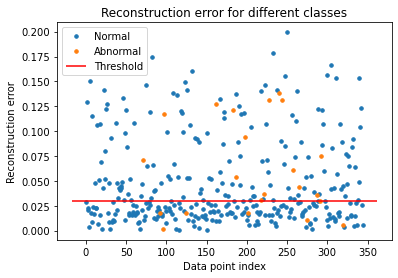

In [19]:
result = recon_err_plot(x_val_s, pred, y_val, .03)

In [20]:
result.head()

,index,Reconstruction_error,True_class
0,638,0.028662,0
1,1047,0.128810,0
2,178,0.023001,0
3,631,0.021038,0
4,1022,0.003986,0


* threshold(cutoff) 값을 조정하면서 precision, recall, f1 을 구해봅시다.
    * threshold(cutoff) 보다 크면, **Abnormal**
    * prec_rec_f1_curve(y, recon_error)
        * x축 : 재구성에러(Anomaly Score라고 부르기도 함)
        * y축 : threshold값을 0부터 조금씩 조정하며 증가시켰을 때의 f1, recall, precision 값(0~1)

<ipython-input-3-758115a526a7>:6: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


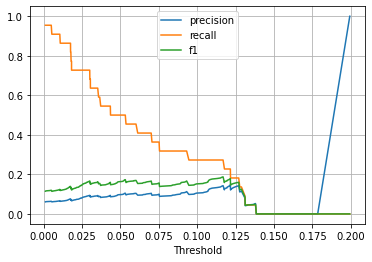

In [21]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 값을 최대화 시키는 threshold 값

In [22]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.11769618792326109

* threshold 값에 따른 classification report
    * classification_report2(y, Reconstruction_error , threshold)

In [23]:
classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[287  36]
 [ 17   5]]


< classification_report >

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       323
           1       0.12      0.23      0.16        22

    accuracy                           0.85       345
   macro avg       0.53      0.56      0.54       345
weighted avg       0.89      0.85      0.87       345



array([[287,  36],
       [ 17,   5]], dtype=int64)

In [24]:
# 수용 할 만한 결과인가요?


### 1.4 [추가] deep dive into reconstruction error
아래 내용은 시간이 허용되는 만큼 진행하고자 합니다.

* reconstruction error를 직접 계산해보고
* reconstruction error에 영향을 가장 많이주는 변수 분석 


#### 1) 실제값과 예측값 합치기

In [25]:
# 실제값을 데이터프레임으로 저장
x_val_s = pd.DataFrame(x_val_s, columns = list(x))

# 예측값을 데이터프레임으로 저장(칼럼명에 prefix : 'Pr_')
pred_col = []
for i in list(x):
    pred_col.append('Pr_'+i)
pred_df = pd.DataFrame(pred, columns = pred_col)

# 합치기
reconErr = pd.concat([x_val_s, pred_df], axis = 1)
reconErr.head()

,Age,Distance,Income,Single,Pr_Age,Pr_Distance,Pr_Income,Pr_Single
0,0.404762,0.607143,0.239705,0.0,0.436141,0.274503,0.294608,0.000000
1,0.738095,0.607143,0.973828,0.0,0.564326,0.307774,0.347962,0.060946
2,0.523810,0.035714,0.128436,0.0,0.432309,0.273509,0.293013,0.000000
3,0.523810,0.000000,0.339547,0.0,0.456025,0.279664,0.302884,0.000000
4,0.452381,0.285714,0.167457,0.0,0.424628,0.271515,0.289816,0.000000


#### 2) reconstruction error 직접 계산

* 각 값끼리의 Squared Error를 구하기.

In [26]:
for v in list(x) :
    v_se, v_pred = 'SE_'+v, 'Pr_'+v
    reconErr[v_se] = np.power(reconErr[v] - reconErr[v_pred], 2)

reconErr.head()

,Age,Distance,Income,Single,Pr_Age,Pr_Distance,Pr_Income,Pr_Single,SE_Age,SE_Distance,SE_Income,SE_Single
0,0.404762,0.607143,0.239705,0.0,0.436141,0.274503,0.294608,0.000000,0.000985,0.110649,0.003014,0.000000
1,0.738095,0.607143,0.973828,0.0,0.564326,0.307774,0.347962,0.060946,0.030196,0.089622,0.391708,0.003714
2,0.523810,0.035714,0.128436,0.0,0.432309,0.273509,0.293013,0.000000,0.008372,0.056546,0.027086,0.000000
3,0.523810,0.000000,0.339547,0.0,0.456025,0.279664,0.302884,0.000000,0.004595,0.078212,0.001344,0.000000
4,0.452381,0.285714,0.167457,0.0,0.424628,0.271515,0.289816,0.000000,0.000770,0.000202,0.014972,0.000000


* 각 행에 대한 mse 계산

In [27]:
reconErr['Recon_Error'] = (reconErr['SE_Age'] + reconErr['SE_Distance'] + reconErr['SE_Income'] + reconErr['SE_Single'])/4
reconErr.head()

,Age,Distance,Income,Single,Pr_Age,Pr_Distance,Pr_Income,Pr_Single,SE_Age,SE_Distance,SE_Income,SE_Single,Recon_Error
0,0.404762,0.607143,0.239705,0.0,0.436141,0.274503,0.294608,0.000000,0.000985,0.110649,0.003014,0.000000,0.028662
1,0.738095,0.607143,0.973828,0.0,0.564326,0.307774,0.347962,0.060946,0.030196,0.089622,0.391708,0.003714,0.128810
2,0.523810,0.035714,0.128436,0.0,0.432309,0.273509,0.293013,0.000000,0.008372,0.056546,0.027086,0.000000,0.023001
3,0.523810,0.000000,0.339547,0.0,0.456025,0.279664,0.302884,0.000000,0.004595,0.078212,0.001344,0.000000,0.021038
4,0.452381,0.285714,0.167457,0.0,0.424628,0.271515,0.289816,0.000000,0.000770,0.000202,0.014972,0.000000,0.003986


#### 3) reconstruction error에 영향을 많이 주는 변수
* 만약, 모델이 적절(?)하다고 판단될 때,
* 모델에 의해 계산된 재구성 에러가 큰 데이터(instance, 행)는 Abnormal 이라고 볼 수 있다.
* 그렇다면, 재구성 에러 계산시 값이 큰 변수가 이상탐지에 중요한 변수로 볼 수 있다.
* 그래서 변수별 mse를 계산해보자.

In [28]:
for v in list(x) :
    print(v.ljust(10, ' '), round(np.mean(reconErr['SE_'+v]),4), round(np.std(reconErr['SE_'+v]),4))

Age        0.0379 0.056
Distance   0.0883 0.1208
Income     0.0602 0.1003
Single     0.0063 0.0158


## 2.실습 : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다. 
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### 2.1 데이터 준비

* 데이터 로딩

In [29]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [30]:
target = 'label'

In [31]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [32]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [35]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


* 스케일링(Optional)

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

* 학습용 데이터 준비

In [37]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train_s[y_train == 0]

In [38]:
x_train0.shape

(1167, 52)

### 2.2 모델링①

* 간단한 hyper parameter 설정

In [39]:
epochs = 50
input_dim = x_train0.shape[1] #num of columns
input_dim

tf.random.set_seed(10)

* 모델 설계 : 다음 그림과 같이 설계하시오.

![](https://github.com/DA4BAM/dataset/blob/master/ae_2.png?raw=true)

In [40]:
clear_session()

input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)

# Decoder
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense (Dense)               (None, 32)                1696      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 52)                1716      
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


* compile + 학습
    * 학습시 x=x_train0, y=x_train0를 입력합니다. (비지도)

In [41]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=epochs,
                          validation_data=(x_val_s, x_val_s)).history

Epoch 1/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.0463 - val_loss: 0.0635 - val_accuracy: 0.5191
Epoch 2/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.5870 - val_loss: 0.0476 - val_accuracy: 0.3376
Epoch 3/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0375 - accuracy: 0.3599 - val_loss: 0.0464 - val_accuracy: 0.4618
Epoch 4/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0.4456 - val_loss: 0.0455 - val_accuracy: 0.4236
Epoch 5/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0356 - accuracy: 0.4507 - val_loss: 0.0449 - val_accuracy: 0.4045
Epoch 6/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.4173 - val_loss: 0.0444 - val_accuracy: 0.4013
Epoch 7/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0350 - accuracy: 0.4310 - val_loss: 0.0438 - val_accuracy: 0.4490
Epoch 8/50
37/37 [==

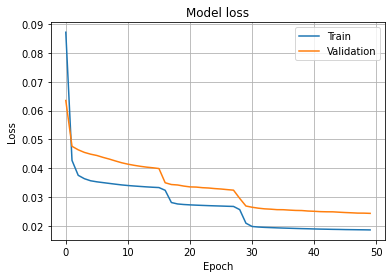

In [42]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

* 예측

In [43]:
pred = autoencoder.predict(x_val_s)

* 재구성 에러 계산

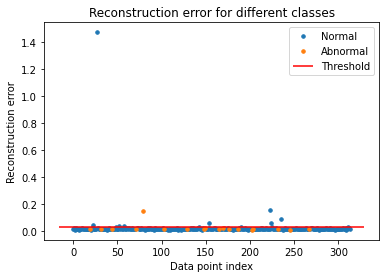

In [44]:
result = recon_err_plot(x_val_s, pred, y_val, .03)

* threshold 값을 조정하면서 precision, recall, f1 을 구해봅시다.

<ipython-input-3-758115a526a7>:6: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


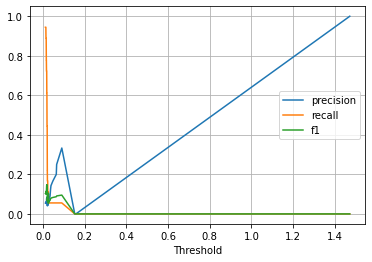

In [45]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 값을 최대화 시키는 threshold 값

In [46]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.018388670093366

* classification_report2 로 평가

In [47]:
classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[176 120]
 [  8  10]]


< classification_report >

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       296
           1       0.08      0.56      0.14        18

    accuracy                           0.59       314
   macro avg       0.52      0.58      0.43       314
weighted avg       0.91      0.59      0.70       314



array([[176, 120],
       [  8,  10]], dtype=int64)

----

### 2.3 모델링②

* hyper parameter 설정

In [48]:
epochs = 50
input_dim = x_train0.shape[1] #num of columns
input_dim

tf.random.set_seed(10)

* 모델 설계 : 다양한 구조를 설계하시오.

In [49]:
clear_session()

input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)

# Decoder
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense (Dense)               (None, 32)                1696      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 52)                1716      
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


* compile + 학습
    * 학습시 x=x_train0, y=x_train0를 입력합니다. (비지도)

In [50]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=epochs,
                          validation_data=(x_val_s, x_val_s)).history

Epoch 1/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0872 - accuracy: 0.0463 - val_loss: 0.0635 - val_accuracy: 0.5191
Epoch 2/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.5870 - val_loss: 0.0476 - val_accuracy: 0.3376
Epoch 3/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0375 - accuracy: 0.3599 - val_loss: 0.0464 - val_accuracy: 0.4618
Epoch 4/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0.4456 - val_loss: 0.0455 - val_accuracy: 0.4236
Epoch 5/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0356 - accuracy: 0.4507 - val_loss: 0.0449 - val_accuracy: 0.4045
Epoch 6/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.4173 - val_loss: 0.0444 - val_accuracy: 0.4013
Epoch 7/50
37/37 [==============================] - 0s 1ms/step - loss: 0.0350 - accuracy: 0.4310 - val_loss: 0.0438 - val_accuracy: 0.4490
Epoch 8/50
37/37 [==

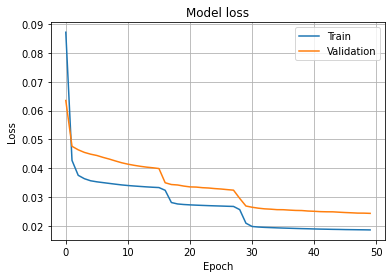

In [51]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

* 예측

In [52]:
pred = autoencoder.predict(x_val_s)

* 재구성 에러 계산

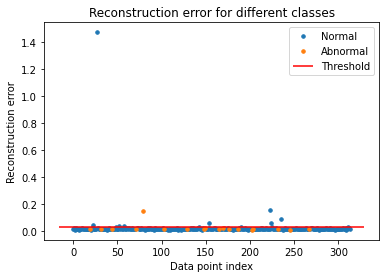

In [53]:
result = recon_err_plot(x_val_s, pred, y_val, .03)

* threshold 값을 조정하면서 precision, recall, f1 을 구해봅시다.

<ipython-input-3-758115a526a7>:6: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


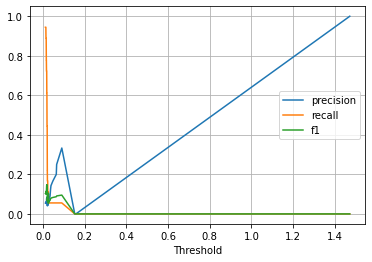

In [54]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 값을 최대화 시키는 threshold 값

In [55]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.018388670093366

* classification_report2 로 평가

In [56]:
classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[176 120]
 [  8  10]]


< classification_report >

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       296
           1       0.08      0.56      0.14        18

    accuracy                           0.59       314
   macro avg       0.52      0.58      0.43       314
weighted avg       0.91      0.59      0.70       314



array([[176, 120],
       [  8,  10]], dtype=int64)